In [2]:
import os
from dotenv import load_dotenv
import geopandas as gpd
from shapely.geometry import Polygon, mapping
import requests 
import json
from requests.auth import HTTPBasicAuth

In [3]:
load_dotenv()
PLANET_API_KEY = os.getenv('API_KEY')

In [4]:

"""
This script reads all shapefiles in a directory, and extracts the AOI polygons 
stored in the shapefile to a geopandas Polygon to query Planet Imagery downloads
through their API. The code logic assumes only one polygon is stored in each
shapefile.

Harrison Myers
6/7/2024

Dependencies: 
    -- os
    -- geopandas (pip install geopandas)
    -- shapely (pip install shapely)
"""

dir_path = '/Users/aidanhayes/Desktop/Planet-Imagery-API/PlanetImageryAOIs'
os.chdir(dir_path)

def getPolygons(folderPath, sitenames):
    """
    Reads all shapefiles in a directory and stores their respective polygons
    in a dictionary
    Params:
        -- folderPath (str, req): Path to folder where shapefiles are stored
    returns:
        -- polygons (dict): Dictionary of polygons indexed by first two letters
                            of site name
    """
    polygons = {}
    for f in os.listdir(folderPath):
        if f.endswith('.shp'): # only read shapefiles
            fpath = os.path.join(folderPath, f) # get path to shapefile
            gdf = gpd.read_file(fpath) # read shapefile
            for geom in gdf.geometry:
                if isinstance(geom, Polygon):
                    polygons[f'{f[:3]}'] = geom
    return polygons



current_dict = getPolygons(dir_path, '_')  

In [5]:
# BASE_URL = 'https://api.planet.com/tasking/v2/orders/'
# auth = HTTPBasicAuth(PLANET_API_KEY, '')
# res = requests.get(url=BASE_URL, auth=auth)
# print(res.status_code)

200


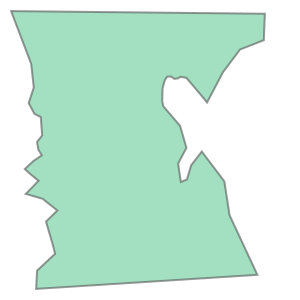

In [6]:
# Stats Seach
current_dict['Mon']

In [7]:
polygon = current_dict['Mon']
geojson_geometry = mapping(polygon)

In [8]:
SEARCH_ENDPOINT = 'https://api.planet.com/data/v1/quick-search'

search_params = {
   "item_types":[
      "PSScene"
   ],
   "filter":{
      "type":"AndFilter",
      "config":[
         {
            "type":"GeometryFilter",
            "field_name":"geometry",
            "config": geojson_geometry
                       
              
         },
         {
            "type":"DateRangeFilter",
            "field_name":"acquired",
            "config":{
               "gte":"2021-11-18T00:00:00Z",
            }
         },
         {
            "type":"StringInFilter",
            "field_name":"quality_category",
            "config":[
               "standard"
            ]
         },
         {
            "type":"AssetFilter",
            "config":[
               "ortho_analytic_8b"
            ]
         },
         {
            "type":"RangeFilter",
            "field_name":"cloud_cover",
            "config":{
               "gte":0,
               "lte":0.75
            },
         },
         {
            "type":"PermissionFilter",
            "config":[
               "assets:download"
            ]
         }
      ]
   }
}
headers = {
    'Authorization': f'api-key {PLANET_API_KEY}',
    'Content-Type': 'application/json'
}
response = requests.post(SEARCH_ENDPOINT, headers=headers, data=json.dumps(search_params))


In [9]:
data_dict = json.loads(response.text)

In [10]:
data_dict

{'field': {'filter.config.0.config.coordinates.0.0': [{'message': '[440979.0789999999, 169543.6361999996, 0.0] is too long'}],
  'filter.config.0.config.coordinates.0.1': [{'message': '[441035.81680000015, 169477.3267000001, 0.0] is too long'}],
  'filter.config.0.config.coordinates.0.10': [{'message': '[441297.4757000003, 168973.0002999995, 0.0] is too long'}],
  'filter.config.0.config.coordinates.0.11': [{'message': '[440548.3716000002, 168925.31079999916, 0.0] is too long'}],
  'filter.config.0.config.coordinates.0.12': [{'message': '[440551.32579999976, 168986.92730000056, 0.0] is too long'}],
  'filter.config.0.config.coordinates.0.13': [{'message': '[440612.52020000014, 169044.3234000001, 0.0] is too long'}],
  'filter.config.0.config.coordinates.0.14': [{'message': '[440603.65759999957, 169078.50789999962, 0.0] is too long'}],
  'filter.config.0.config.coordinates.0.15': [{'message': '[440581.7120000003, 169153.2072999999, 0.0] is too long'}],
  'filter.config.0.config.coordina